# Initial Data Exploration:

The most improtant steps are:

- Identify quality issues (e.g. missing values, wrong measurements, …)
- Assess feature quality – how relevant is a certain measurement (e.g. use correlation matrix)
- Get an idea on the value distribution of your data using statistical measures and visualizations



# Downloading data

In [298]:
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data

--2019-10-11 13:29:15--  https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3974305 (3.8M) [application/x-httpd-php]
Saving to: ‘adult.data.3’

100%[======================================>] 3,974,305   14.1MB/s   in 0.3s   

2019-10-11 13:29:15 (14.1 MB/s) - ‘adult.data.3’ saved [3974305/3974305]



In [299]:
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.test

--2019-10-11 13:29:16--  https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.test
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2003153 (1.9M) [application/x-httpd-php]
Saving to: ‘adult.test.3’

100%[======================================>] 2,003,153   8.52MB/s   in 0.2s   

2019-10-11 13:29:17 (8.52 MB/s) - ‘adult.test.3’ saved [2003153/2003153]



In [300]:
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.names

--2019-10-11 13:29:18--  https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.names
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5229 (5.1K) [application/x-httpd-php]
Saving to: ‘adult.names.3’

100%[======================================>] 5,229       --.-K/s   in 0s      

2019-10-11 13:29:18 (116 MB/s) - ‘adult.names.3’ saved [5229/5229]



In [301]:
!ls

adult.data    adult.data.3   adult.names.2  adult.test.1
adult.data.1  adult.names    adult.names.3  adult.test.2
adult.data.2  adult.names.1  adult.test     adult.test.3


# Importing libs

In [303]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

# Loading data

In [304]:
data_headers = ['age', 'workclass', 'final_weight', 'education', 'education_duration', 
                'marital_status', 'occupation', 'family_role', 'race', 'sex', 
                'capital_gain', 'capital_loss', 'hours_per_week', 'native_country', 'target']

print('Data attributes: ', len(data_headers))

Data attributes:  15


In [305]:
part1 = pd.read_csv('adult.data', header = None, names = data_headers)
part2 = pd.read_csv('adult.test', header = None, skiprows = 1, names = data_headers)

In [306]:
print('First part of the data: ', part1.shape)
print('Second part of the data: ', part2.shape)
df = pd.concat([part1, part2], ignore_index = True, axis = 0)
print('total size of the data:', data.shape)

First part of the data:  (32561, 15)
Second part of the data:  (16281, 15)
total size of the data: (48842, 15)


In [307]:
df.head()

,age,workclass,final_weight,education,education_duration,marital_status,occupation,family_role,race,sex,capital_gain,capital_loss,hours_per_week,native_country,target
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


# Print data info

In [308]:
print(df.shape)
print('-----------Missing values---------')
print(df.isnull().sum())
print('-----------Null values------------')
print(df.isna().sum())
print('-----------Data types-------------')
print(df.dtypes)
print('-----------Memory usage (MB)------')
print(np.round(df.memory_usage(deep = True).sum() / 1024**2, 2))

(48842, 15)
-----------Missing values---------
age                   0
workclass             0
final_weight          0
education             0
education_duration    0
marital_status        0
occupation            0
family_role           0
race                  0
sex                   0
capital_gain          0
capital_loss          0
hours_per_week        0
native_country        0
target                0
dtype: int64
-----------Null values------------
age                   0
workclass             0
final_weight          0
education             0
education_duration    0
marital_status        0
occupation            0
family_role           0
race                  0
sex                   0
capital_gain          0
capital_loss          0
hours_per_week        0
native_country        0
target                0
dtype: int64
-----------Data types-------------
age                    int64
workclass             object
final_weight           int64
education             object
education_duration   

# Remove Duplicated rows

In [309]:
print('Number of duplicates:', len(df[df.duplicated()]))

Number of duplicates: 29


In [310]:
df = df.drop_duplicates(keep = 'first')
print('Number of duplicates:', len(df[df.duplicated()]))

Number of duplicates: 0


# Target

In [311]:
df['target'].value_counts()

 <=50K     24698
 <=50K.    12430
 >50K       7839
 >50K.      3846
Name: target, dtype: int64

In [312]:
df['target'] = df['target'].str.replace('.', '')
df['target'].value_counts()

 <=50K    37128
 >50K     11685
Name: target, dtype: int64

# Age vs target

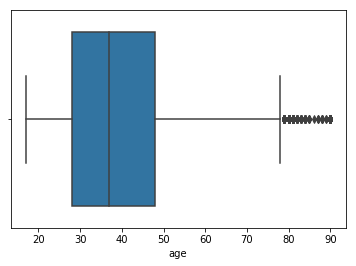

In [313]:
sns.boxplot(df['age'])
plt.show()

In [314]:
print('People whose age > 80 years: ', len(df[df['age'] > 80]))

People whose age > 80 years:  147


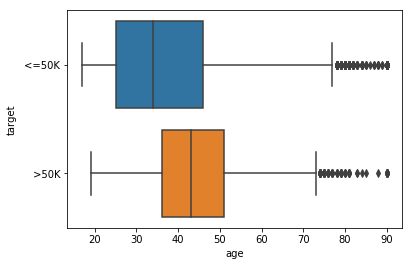

In [315]:
sns.boxplot(x = df['age'], y = df['target'])
plt.show()

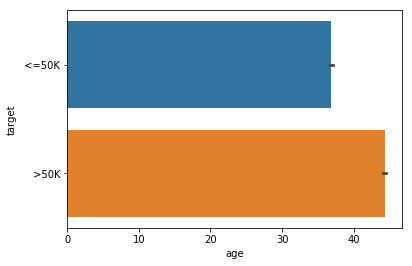

In [316]:
sns.barplot(x = df['age'], y = df['target'])
plt.show()

# Workclass vs target

In [317]:
df['workclass'].value_counts()

 Private             33879
 Self-emp-not-inc     3861
 Local-gov            3136
 ?                    2799
 State-gov            1981
 Self-emp-inc         1694
 Federal-gov          1432
 Without-pay            21
 Never-worked           10
Name: workclass, dtype: int64

In [318]:
df['workclass'] = df['workclass'].str.replace('?', 'unknow')

(array([0, 1, 2, 3, 4, 5, 6, 7, 8]), <a list of 9 Text xticklabel objects>)

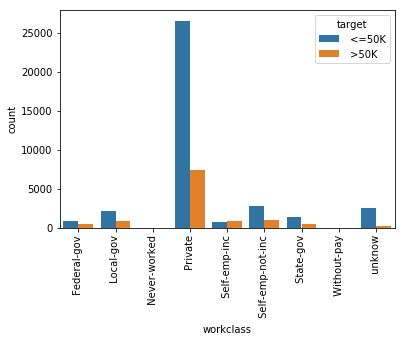

In [319]:
gb = df.groupby(by = ['workclass', 'target']).agg({'age': 'count'})
gb.columns = ['count']
gb = gb.reset_index()
ax = sns.barplot(x = 'workclass', y = 'count', hue = 'target', data = gb)
plt.xticks(rotation = 90)

# Final_weight vs target

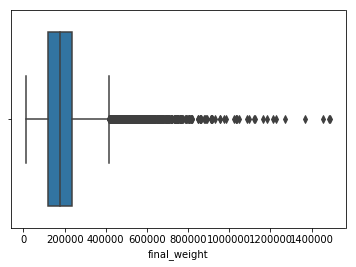

In [320]:
sns.boxplot(x = 'final_weight', data = df)
plt.show()

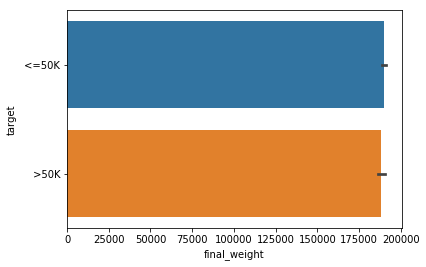

In [321]:
sns.barplot(x = 'final_weight', y = 'target', data = df)

# Education vs target

In [322]:
df['education'].value_counts()

 HS-grad         15777
 Some-college    10869
 Bachelors        8020
 Masters          2656
 Assoc-voc        2060
 11th             1812
 Assoc-acdm       1601
 10th             1389
 7th-8th           954
 Prof-school       834
 9th               756
 12th              656
 Doctorate         594
 5th-6th           508
 1st-4th           245
 Preschool          82
Name: education, dtype: int64

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15]),
 <a list of 16 Text xticklabel objects>)

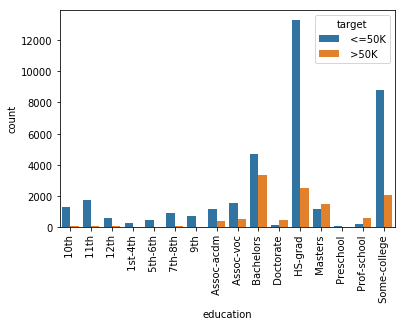

In [323]:
gb = df.groupby(by = ['education', 'target']).agg({'age': 'count'})
gb.columns = ['count']
gb = gb.reset_index()
ax = sns.barplot(x = 'education', y = 'count', hue = 'target', data = gb)
plt.xticks(rotation = 90)

# Education_duration vs target

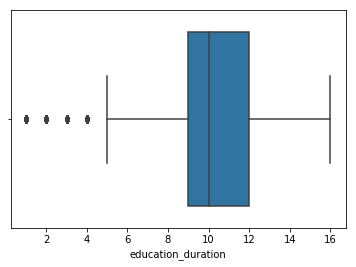

In [324]:
sns.boxplot(x = 'education_duration', data = df)
plt.show()

In [325]:
print('People whose study duration < 5: ', len(df[df['education_duration'] < 5]))

People whose study duration < 5:  1789


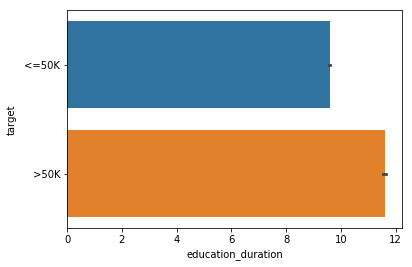

In [326]:
sns.barplot(x = 'education_duration', y = 'target', data = df)
plt.show()

# Marital_status vs target

In [327]:
df['marital_status'].value_counts()

 Married-civ-spouse       22372
 Never-married            16098
 Divorced                  6630
 Separated                 1530
 Widowed                   1518
 Married-spouse-absent      628
 Married-AF-spouse           37
Name: marital_status, dtype: int64

(array([0, 1, 2, 3, 4, 5, 6]), <a list of 7 Text xticklabel objects>)

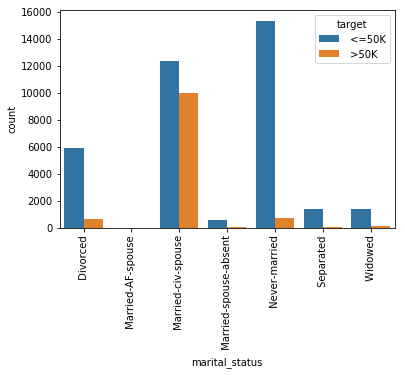

In [328]:
gb = df.groupby(by = ['marital_status', 'target']).agg({'age': 'count'})
gb.columns = ['count']
gb = gb.reset_index()
ax = sns.barplot(x = 'marital_status', y = 'count', hue = 'target', data = gb)
plt.xticks(rotation = 90)

# Occupation vs target

In [329]:
df['occupation'].value_counts()

 Prof-specialty       6167
 Craft-repair         6107
 Exec-managerial      6084
 Adm-clerical         5608
 Sales                5504
 Other-service        4919
 Machine-op-inspct    3019
 ?                    2809
 Transport-moving     2355
 Handlers-cleaners    2071
 Farming-fishing      1487
 Tech-support         1445
 Protective-serv       983
 Priv-house-serv       240
 Armed-Forces           15
Name: occupation, dtype: int64

In [330]:
df['occupation'] = df['occupation'].str.replace('?', 'unknown')

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14]),
 <a list of 15 Text xticklabel objects>)

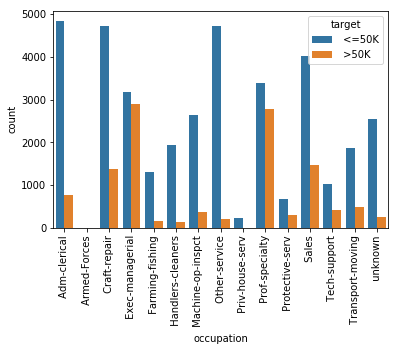

In [331]:
gb = df.groupby(by = ['occupation', 'target']).agg({'age': 'count'})
gb.columns = ['count']
gb = gb.reset_index()
ax = sns.barplot(x = 'occupation', y = 'count', hue = 'target', data = gb)
plt.xticks(rotation = 90)

# Family_role vs target

In [332]:
df['family_role'].value_counts()

 Husband           19709
 Not-in-family     12567
 Own-child          7576
 Unmarried          5124
 Wife               2331
 Other-relative     1506
Name: family_role, dtype: int64

(array([0, 1, 2, 3, 4, 5]), <a list of 6 Text xticklabel objects>)

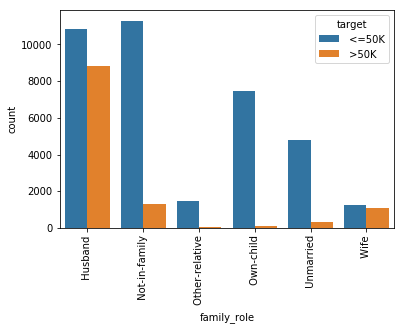

In [333]:
gb = df.groupby(by = ['family_role', 'target']).agg({'age': 'count'})
gb.columns = ['count']
gb = gb.reset_index()
ax = sns.barplot(x = 'family_role', y = 'count', hue = 'target', data = gb)
plt.xticks(rotation = 90)

# Race vs target

In [334]:
df['race'].value_counts()

 White                 41736
 Black                  4683
 Asian-Pac-Islander     1518
 Amer-Indian-Eskimo      470
 Other                   406
Name: race, dtype: int64

(array([0, 1, 2, 3, 4]), <a list of 5 Text xticklabel objects>)

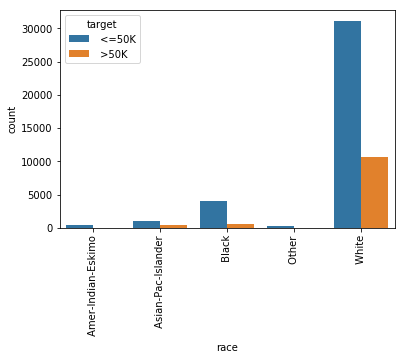

In [335]:
gb = df.groupby(by = ['race', 'target']).agg({'age': 'count'})
gb.columns = ['count']
gb = gb.reset_index()
ax = sns.barplot(x = 'race', y = 'count', hue = 'target', data = gb)
plt.xticks(rotation = 90)

# Sex vs target

In [336]:
df['sex'].value_counts()

 Male      32631
 Female    16182
Name: sex, dtype: int64

(array([0, 1]), <a list of 2 Text xticklabel objects>)

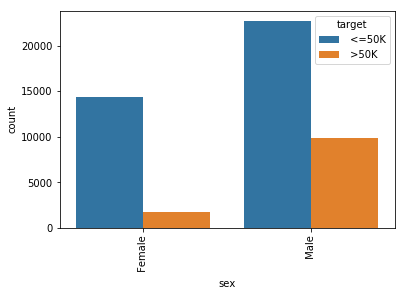

In [337]:
gb = df.groupby(by = ['sex', 'target']).agg({'age': 'count'})
gb.columns = ['count']
gb = gb.reset_index()
ax = sns.barplot(x = 'sex', y = 'count', hue = 'target', data = gb)
plt.xticks(rotation = 90)

# Capital_gain vs target

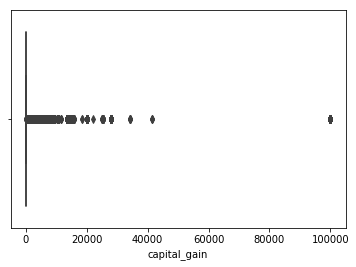

In [338]:
sns.boxplot(x = 'capital_gain', data = df)
plt.show()

In [339]:
print('People with capital_gain > 80000: ', len(df[df['capital_gain'] < 80000]))

People with capital_gain > 80000:  48569


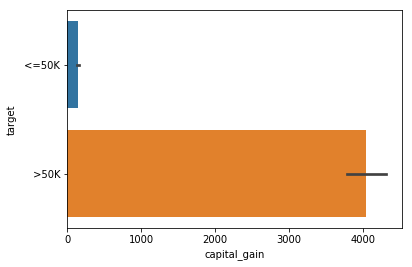

In [340]:
sns.barplot(x = 'capital_gain', y = 'target', data = df)
plt.show()

# Capital_loss vs target

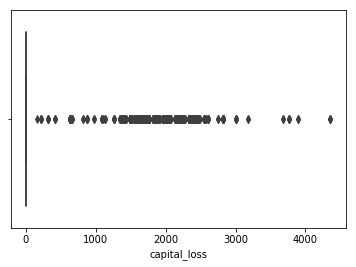

In [341]:
sns.boxplot(x = 'capital_loss', data = df)
plt.show()

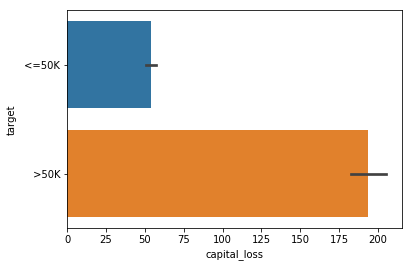

In [342]:
sns.barplot(x = 'capital_loss', y = 'target', data = df)
plt.show()

# Hours_per_week vs target

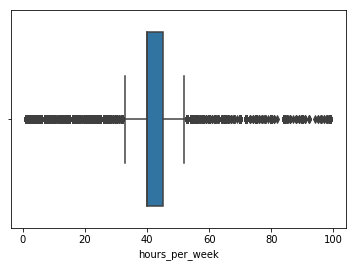

In [343]:
sns.boxplot(x = 'hours_per_week', data = df)
plt.show()

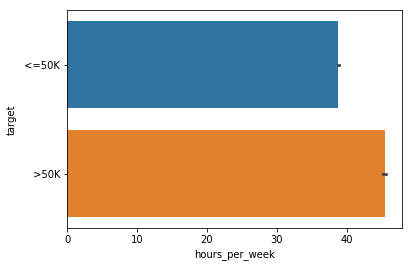

In [344]:
sns.barplot(x = 'hours_per_week', y = 'target', data = df)
plt.show()

# Native_country vs target

In [345]:
df['native_country'].value_counts()

 United-States                 43810
 Mexico                          947
 ?                               856
 Philippines                     295
 Germany                         206
 Puerto-Rico                     184
 Canada                          182
 El-Salvador                     155
 India                           151
 Cuba                            138
 England                         127
 China                           122
 South                           115
 Jamaica                         106
 Italy                           105
 Dominican-Republic              103
 Japan                            92
 Poland                           87
 Guatemala                        86
 Vietnam                          86
 Columbia                         85
 Haiti                            75
 Portugal                         67
 Taiwan                           65
 Iran                             59
 Nicaragua                        49
 Greece                           49
 

In [346]:
df['native_country'] = df['native_country'].str.replace('?', 'unknown')

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41]),
 <a list of 42 Text xticklabel objects>)

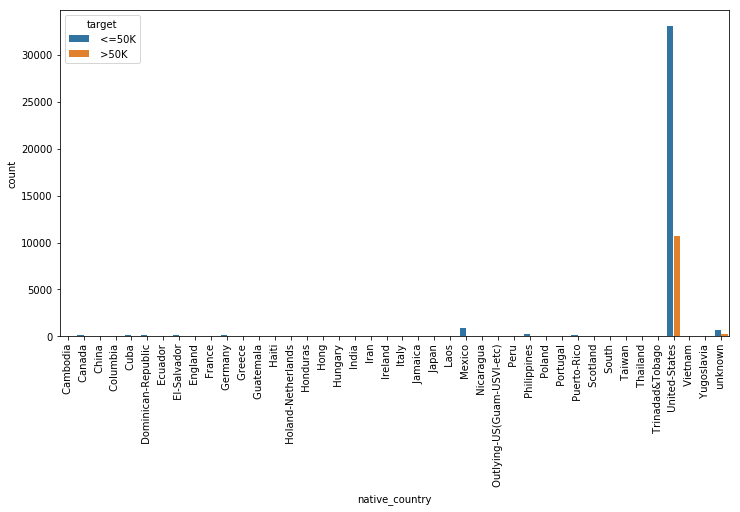

In [347]:
gb = df.groupby(by = ['native_country', 'target']).agg({'age': 'count'})
gb.columns = ['count']
gb = gb.reset_index()
fig, ax = plt.subplots(figsize = (12, 6))
sns.barplot(x = 'native_country', y = 'count', hue = 'target', data = gb)
plt.xticks(rotation = 90)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40]), <a list of 41 Text xticklabel objects>)

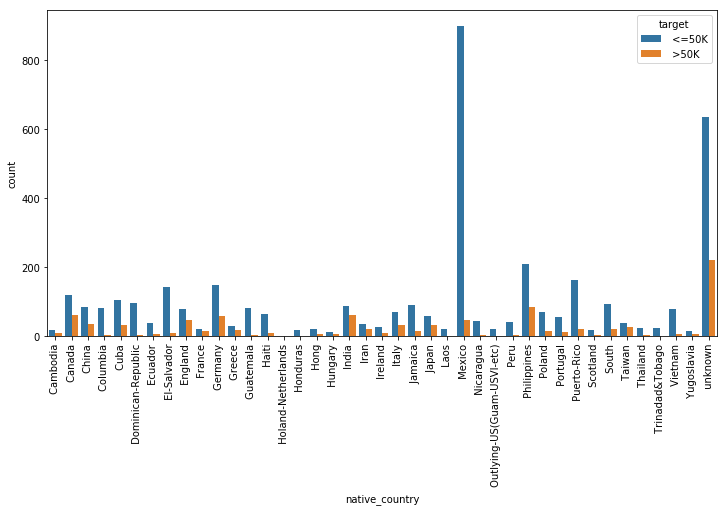

In [348]:
new_gb = gb[gb['count'] < 10692]
fig, ax = plt.subplots(figsize = (12, 6))
sns.barplot(x = 'native_country', y = 'count', hue = 'target', data = new_gb)
plt.xticks(rotation = 90)

# Correlation Map

In [349]:
from sklearn.preprocessing import LabelEncoder

In [350]:
new_df = df.copy()

In [351]:
for col in new_df.columns:
    if new_df[col].dtype == 'object':
        lb = LabelEncoder()
        new_df[col] = lb.fit_transform(new_df[col])

In [352]:
corr = new_df.corr()

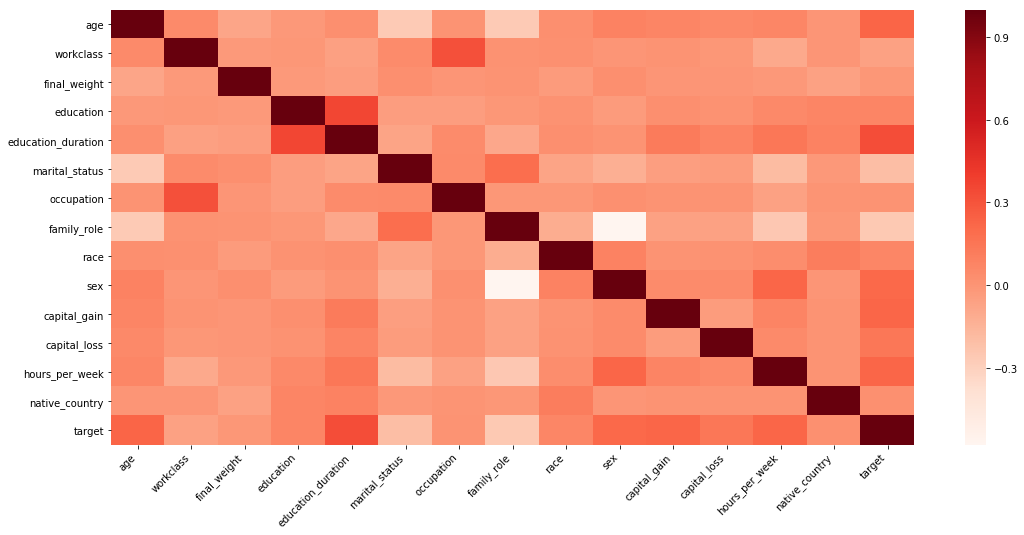

In [353]:
f, ax = plt.subplots(figsize = (18, 8))
ax = sns.heatmap(corr, cmap = plt.cm.Reds)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation = 45,
    horizontalalignment = 'right'
)
plt.show()

In [354]:
# The code was removed by Watson Studio for sharing.

In [ ]:
project.save_data("data.csv", df.to_csv(index = 0))